In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### 벡터스토어 및 프롬프트 준비

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", streaming=True)
small_llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)

In [3]:
from langchain_openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings(model="text-embedding-3-large")

from langchain_chroma import Chroma
vector_store = Chroma(
    collection_name="chroma_tax",           # 저장할 때 사용한 collection_name과 동일하게
    embedding_function=embedding,
    persist_directory="./chroma_tax"        # 저장된 디렉토리 경로
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [4]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph, MessagesState

class AgentState(MessagesState):
    pass #messages는 있음

graph_builder = StateGraph(AgentState)

In [5]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
#하나의 문서로 통합

### 툴 함수로 래핑

In [6]:
from langchain_core.tools import tool

@tool
def retrieve_tool(query: str) -> str:
    """질문에 대해 관련 문서를 검색하여 반환하는 도구입니다."""
    docs = retriever.invoke(query)
    
    return format_docs(docs)
    

In [7]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser 

@tool
def generate_tool(context: str, question: str) -> str:
    """검색된 문서(context)와 질문을 바탕으로 응답을 생성하는 도구입니다."""
    prompt = PromptTemplate.from_template("""
    다음은 질문에 대한 문서입니다. 문서를 참고하여 질문에 대한 정확한 답변을 생성해 주세요. 
    
    [문서]
    {context}
    
    [질문]
    {question}                                     
    """)
    chain = prompt | llm | StrOutputParser()
    
    return chain.invoke({'context': context, 'question': question})
    

In [8]:
from urllib import response
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']
    
rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해 주세요.
사전: {dictionary}                                              
질문: {{query}}
""")

In [9]:
@tool
def rewrite_tool(query: str) -> str:
    """
    사용자의 질문을 사전을 고려하여 변경합니다.     
    """
   
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()    
    
    return rewrite_chain.invoke({'query': query})

### 툴 리스트, ToolNode 생성, LLM에 툴 바인딩

In [10]:
from langgraph.prebuilt import ToolNode

tool_list = [retrieve_tool, generate_tool, rewrite_tool]
tool_node = ToolNode(tool_list)
llm_with_tools =llm.bind_tools(tool_list)

### agent 함수 정의

In [11]:
from langchain_core.messages import HumanMessage, SystemMessage

def agent(state: AgentState) -> AgentState:
    system_msg = SystemMessage(content="너는 사용자 질문을 검색, 리라이팅, 응답 생성 도구로 해결하는 AI입니다.")
    messages = [system_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    
    return {"messages": [response]}
    

### 그래프 노드 및 에지 연결

In [ ]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node('agent', agent) #'agent' 노드: 에이전트 함수
graph_builder.add_node('tools', tool_node) #'tools' 노드: 툴 실행 노드

from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges('agent', tools_condition) #tool_condition : tool을 사용할지말지, 어느 tool로 갈지 판단
graph_builder.add_edge('tools', 'agent')

### 그래프 컴파일 및 실행

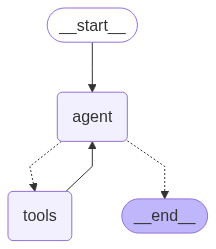

In [13]:
graph = graph_builder.compile()

graph

In [14]:
from langchain_core.messages import HumanMessage, SystemMessage

query = "연봉 5천만원 직장인의 소득세는 얼마인가요?"
init_state = {"messages": [HumanMessage(content=query)]}

for chunk in graph.stream(init_state, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

연봉 5천만원 직장인의 소득세는 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  rewrite_tool (call_ePQeEeCfcYeemIazqjiw8nmj)
 Call ID: call_ePQeEeCfcYeemIazqjiw8nmj
  Args:
    query: 연봉 5천만원 직장인의 소득세는 얼마인가요?
================================= Tool Message =================================
Name: rewrite_tool

거주자의 연봉 5천만원 소득세는 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  retrieve_tool (call_24oNGxSojwIqLfwxpP2Bhpvo)
 Call ID: call_24oNGxSojwIqLfwxpP2Bhpvo
  Args:
    query: 거주자의 연봉 5천만원 소득세는 얼마인가요?
================================= Tool Message =================================
Name: retrieve_tool

③ 제1항 및 제2항에 따른 이자등 상당액의 계산방법과 그 밖에 필요한 사항은 대통령령으로 정한다.

[전문개정 2009. 12. 31.]



제46조(채권 등에 대한 소득금액의 계산 특례) ① 거주자가 제16조제1항제1호ㆍ제2호ㆍ제2호의2ㆍ제5호 및 제6호에 해당하는 채권 또는 증권과 타인에게 양도가 가능한 증권으로서 대통령령으로 정하는 것(이하 이 조, 제133조의2 및 제156